In [45]:
# 1. traditional backwards feature selection: take a feature out, retrain model without feature and see how performance changed. features who droppage least affects the
# model performance have love impact on predictive performance and should be permanently dropped
# 2. sensitivity analysis +backwards elimination feature selection. measuring how variance in each feature affects the output. THis method has different variants depending on the exact model
# (look into partial dependence plots)

In [46]:
%pip install ucimlrepo

###Loading the data set

In [47]:
from ucimlrepo import fetch_ucirepo
from ucimlrepo import list_available_datasets


# fetch dataset
wine_quality = fetch_ucirepo(id=186)


# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets



#X.head()
#y.head()
# variable information
#print(wine_quality.variables)

###Data Preprocessing: want to understand how the data is distributed and perfoming cleaning if necesary

<Axes: xlabel='quality'>

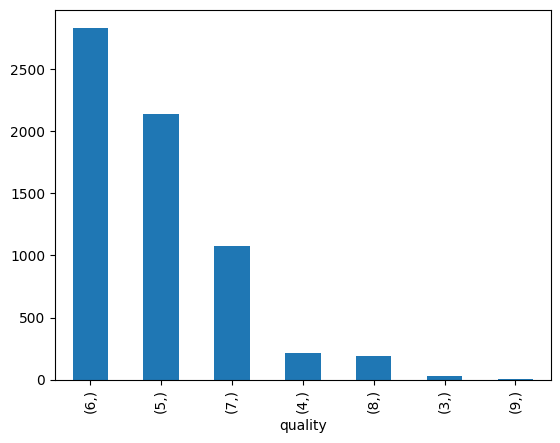

In [48]:
# histogram to give an idea of how imbalanced the quality is
#from matplotlib import pyplot as plt
#import seaborn as sns

y.value_counts().plot(kind='bar')

In [49]:
#X.describe()

#Model A (without SMOTE)



In [50]:
!pip install imbalanced-learn

###Split the data

In [51]:
from sklearn.model_selection import train_test_split
import pandas as pd

y_flat = y.values.ravel()
X_train, X_temp, y_train, y_temp = train_test_split(X,y_flat,train_size=0.7,   random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,train_size=0.5,  random_state=17)

###Check for imbalance in the training split

<Axes: xlabel='0'>

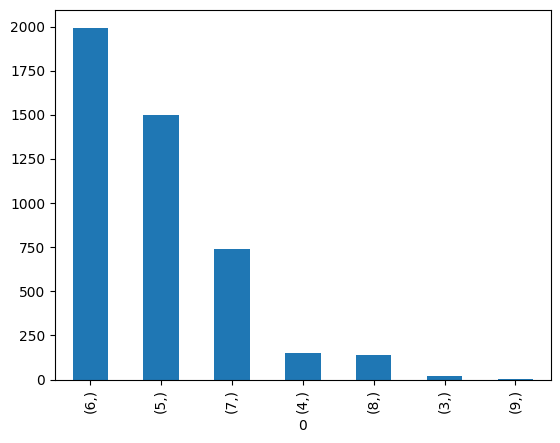

In [52]:
(pd.DataFrame(y_train)).value_counts().plot(kind='bar')

###I think its natural to have more normal wines that excellent ones so I would model with and without imbalance handling

In [53]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline as skPipeline
from sklearn.preprocessing import StandardScaler

param_Grid = [
    # Linear kernel
    {
        'svc__kernel': ['linear'],
        'svc__C':  [0.5, 1,3],
        'svc__class_weight': [None, 'balanced']
    },

    # RBF kernel
    {
        'svc__kernel': ['rbf'],
        'svc__C': [0.5, 1,3],
        'svc__gamma': ['scale', 'auto'], #[0.001, 0.01, 0.1],
        'svc__class_weight': [None, 'balanced']
    },

    # Polynomial kernel
    {
        'svc__kernel': ['poly'],
        'svc__C':  [0.5, 1,3],
        'svc__degree': [ 2,3],
        'svc__gamma': ['scale', 'auto'],
        'svc__coef0': [0, 0.5, 1],
        'svc__class_weight': [None, 'balanced']
    }
]

scoringList ={
     'f1_macro': 'f1_macro',
    'accuracy': 'accuracy'
}

pipe = skPipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC( ))
])


grid1 = GridSearchCV(
    estimator=pipe,
    param_grid=param_Grid,
    scoring=scoringList,
    refit= 'f1_macro',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=17),
    verbose=2,
    n_jobs= -1
)

grid1.fit(X_train, y_train)

# Convert all cv_results_ into a DataFrame
results = pd.DataFrame(grid1.cv_results_)

# Display all columns including per-fold scores
pd.set_option('display.max_columns', None)


best_index = grid1.best_index_
best_params = grid1.best_params_

all_metrics_for_best = {
    metric: grid1.cv_results_[f'mean_test_{metric}'][best_index]
    for metric in scoringList
}

print("Best parameters:", best_params)
print("All metrics for best params:", all_metrics_for_best)

print()
# Evaluate on the val set
val_accuracy = grid1.best_estimator_.score(X_val, y_val)

print("Val accuracy:", val_accuracy)


print('Train accuracy:', grid1.best_estimator_.score(X_train, y_train))

results#.sort_values(by='mean_test_accuracy', ascending=False, inplace=True)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
Best parameters: {'svc__C': 3, 'svc__class_weight': None, 'svc__coef0': 1, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}
All metrics for best params: {'f1_macro': np.float64(0.3025180825436304), 'accuracy': np.float64(0.5691687638420834)}

Val accuracy: 0.558974358974359
Train accuracy: 0.6496591159005938


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__class_weight,param_svc__kernel,param_svc__gamma,param_svc__coef0,param_svc__degree,params,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,1.434470,0.054027,0.475148,0.123922,0.5,None,linear,NaN,NaN,NaN,"{'svc__C': 0.5, 'svc__class_weight': None, 'sv...",0.175232,0.167884,0.175911,0.173009,0.003634,82,0.542216,0.524406,0.543234,0.536619,0.008646,35
1,2.706079,0.350858,0.664562,0.173116,0.5,balanced,linear,NaN,NaN,NaN,"{'svc__C': 0.5, 'svc__class_weight': 'balanced...",0.220567,0.181338,0.198867,0.200257,0.016045,79,0.346306,0.260554,0.292409,0.299756,0.035391,90
2,2.537563,0.247809,0.567680,0.158043,1.0,None,linear,NaN,NaN,NaN,"{'svc__C': 1, 'svc__class_weight': None, 'svc_...",0.175232,0.167884,0.175407,0.172841,0.003506,84,0.542216,0.524406,0.541914,0.536179,0.008325,37
3,3.459763,0.325238,0.465698,0.101382,1.0,balanced,linear,NaN,NaN,NaN,"{'svc__C': 1, 'svc__class_weight': 'balanced',...",0.221710,0.185534,0.199122,0.202122,0.014920,77,0.349604,0.263193,0.293729,0.302175,0.035779,88
4,2.799321,0.828997,0.415315,0.068635,3.0,None,linear,NaN,NaN,NaN,"{'svc__C': 3, 'svc__class_weight': None, 'svc_...",0.175232,0.168143,0.175407,0.172927,0.003384,83,0.542216,0.525066,0.541914,0.536399,0.008015,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1.400945,0.153982,0.269129,0.003363,3.0,balanced,poly,auto,0.5,3.0,"{'svc__C': 3, 'svc__class_weight': 'balanced',...",0.285543,0.258920,0.288778,0.277747,0.013378,15,0.472296,0.428100,0.462046,0.454147,0.018887,52
86,1.187700,0.018414,0.291461,0.010536,3.0,balanced,poly,scale,1.0,2.0,"{'svc__C': 3, 'svc__class_weight': 'balanced',...",0.260300,0.239231,0.247262,0.248931,0.008682,33,0.423483,0.394459,0.398680,0.405541,0.012804,72
87,1.207392,0.015973,0.292671,0.013445,3.0,balanced,poly,auto,1.0,2.0,"{'svc__C': 3, 'svc__class_weight': 'balanced',...",0.260300,0.239231,0.247262,0.248931,0.008682,33,0.423483,0.394459,0.398680,0.405541,0.012804,72
88,1.399004,0.022438,0.272786,0.002135,3.0,balanced,poly,scale,1.0,3.0,"{'svc__C': 3, 'svc__class_weight': 'balanced',...",0.285006,0.264688,0.291876,0.280524,0.011543,11,0.465040,0.433377,0.461386,0.453268,0.014143,54


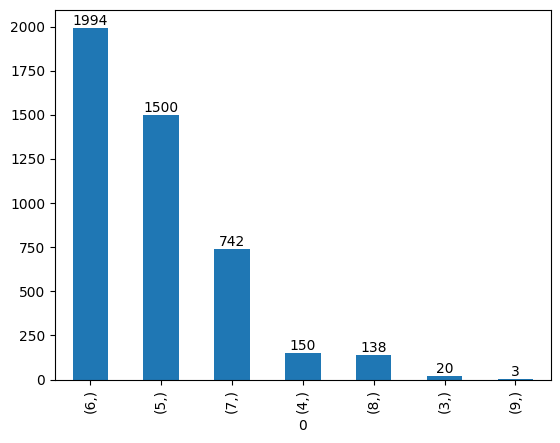

In [54]:
ax = (pd.DataFrame(y_train)).value_counts().plot(kind='bar')
#ax = (pd.DataFrame(y_test)).value_counts().plot(kind='bar')

# Add labels to each bar
for container in ax.containers:
    ax.bar_label(container)

#Modeling with SMOTE

In [55]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import RandomOverSampler


class SafeSMOTE(SMOTE):
    def fit_resample(self, X, y):
        unique, counts = np.unique(y, return_counts=True)
        if np.min(counts) <= self.k_neighbors:
            print("Not enough samples for SMOTE, switching to RandomOverSampler.")
            ros = RandomOverSampler(random_state=self.random_state)
            return ros.fit_resample(X, y)
        return super().fit_resample(X, y)



param_Grid = [
    # Linear kernel
    {
        'svc__kernel': ['linear'],
        'svc__C': [0.5, 1]
    },

    # RBF kernel
    {
        'svc__kernel': ['rbf'],
        'svc__C': [0.1, 0.5],
        'svc__gamma': ['scale', 'auto']#[0.001, 0.01, 0.1]
    },

    # Polynomial kernel
    {
        'svc__kernel': ['poly'],
        'svc__C': [0.1, 0.5 ],
        'svc__degree': [ 2,4],
        'svc__gamma': ['scale', 'auto'],
        'svc__coef0': [0, 0.5,0.7]
    }
]

scoringList ={
    'f1_macro': 'f1_macro',
    'accuracy': 'accuracy'
}

pipe = imbPipeline([
    ('scaler', StandardScaler()),  # scale features
    ('smote', SafeSMOTE(random_state=17, k_neighbors=2)),
    ('svc', SVC())  # classifier
])

grid2 = GridSearchCV(
    estimator = pipe,
    param_grid = param_Grid,
    scoring = scoringList,
    refit= 'f1_macro',
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=17),
    verbose=2,
    n_jobs= -1
)


grid2.fit(X_train, y_train)

# Convert all cv_results_ into a DataFrame
results = pd.DataFrame(grid2.cv_results_)

# Display all columns including per-fold scores
pd.set_option('display.max_columns', None)


best_index = grid2.best_index_
best_params = grid2.best_params_

all_metrics_for_best = {
    metric: grid2.cv_results_[f'mean_test_{metric}'][best_index]
    for metric in scoringList
}

print("Best parameters:", best_params)
print("All metrics for best params:", all_metrics_for_best)


print()
# Evaluate on the val set
val_accuracy = grid2.best_estimator_.score(X_val, y_val)

print("Val accuracy:", val_accuracy)

print('Train accuracy:', grid2.best_estimator_.score(X_train, y_train))
results

Fitting 2 folds for each of 30 candidates, totalling 60 fits
Best parameters: {'svc__C': 0.5, 'svc__coef0': 0.5, 'svc__degree': 4, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}
All metrics for best params: {'f1_macro': np.float64(0.2904056366018879), 'accuracy': np.float64(0.47701633763491036)}

Val accuracy: 0.442051282051282
Train accuracy: 0.5953375852210249


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__kernel,param_svc__gamma,param_svc__coef0,param_svc__degree,params,split0_test_f1_macro,split1_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_accuracy,split1_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,4.045199,0.242425,0.738668,0.005478,0.5,linear,NaN,NaN,NaN,"{'svc__C': 0.5, 'svc__kernel': 'linear'}",0.221668,0.195658,0.208663,0.013005,28,0.349604,0.276287,0.312946,0.036659,30
1,6.968387,0.260152,0.719512,0.018292,1.0,linear,NaN,NaN,NaN,"{'svc__C': 1, 'svc__kernel': 'linear'}",0.222314,0.196347,0.209331,0.012984,27,0.350484,0.276287,0.313385,0.037098,29
2,2.871062,0.031074,1.524732,0.018660,0.1,rbf,scale,NaN,NaN,"{'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__k...",0.252143,0.228260,0.240202,0.011941,23,0.408531,0.361637,0.385084,0.023447,24
3,2.805992,0.002437,1.915700,0.306408,0.1,rbf,auto,NaN,NaN,"{'svc__C': 0.1, 'svc__gamma': 'auto', 'svc__ke...",0.259815,0.223567,0.241691,0.018124,20,0.418206,0.364276,0.391241,0.026965,23
4,3.140761,0.397631,1.354956,0.033214,0.5,rbf,scale,NaN,NaN,"{'svc__C': 0.5, 'svc__gamma': 'scale', 'svc__k...",0.265080,0.250573,0.257826,0.007253,12,0.431838,0.406511,0.419175,0.012663,14
5,1.984802,0.030725,1.292802,0.029490,0.5,rbf,auto,NaN,NaN,"{'svc__C': 0.5, 'svc__gamma': 'auto', 'svc__ke...",0.266964,0.254543,0.260753,0.006211,10,0.441073,0.410471,0.425772,0.015301,13
6,2.955692,0.074650,0.827647,0.022927,0.1,poly,scale,0.0,2.0,"{'svc__C': 0.1, 'svc__coef0': 0, 'svc__degree'...",0.201400,0.203030,0.202215,0.000815,30,0.386544,0.350198,0.368371,0.018173,25
7,3.709308,0.367703,1.221951,0.131122,0.1,poly,auto,0.0,2.0,"{'svc__C': 0.1, 'svc__coef0': 0, 'svc__degree'...",0.204474,0.212320,0.208397,0.003923,29,0.375550,0.356357,0.365953,0.009596,26
8,3.253494,0.107370,0.804731,0.044328,0.1,poly,scale,0.0,4.0,"{'svc__C': 0.1, 'svc__coef0': 0, 'svc__degree'...",0.212024,0.238424,0.225224,0.013200,24,0.444151,0.447426,0.445789,0.001638,12
9,2.870427,0.197806,0.762044,0.020446,0.1,poly,auto,0.0,4.0,"{'svc__C': 0.1, 'svc__coef0': 0, 'svc__degree'...",0.230574,0.254031,0.242303,0.011728,19,0.456904,0.454905,0.455905,0.000999,10


#Choosing a the best model and then performing Feature Selection

In [56]:
from sklearn.inspection import permutation_importance

# have t make sure we feed the same data structures to the model
'''y_test = pd.DataFrame(y_test)
y_train = pd.DataFrame(y_train)
y_val =   pd.DataFrame(y_val)'''

# Select best model for feature selection and label
FS_model, Type  = (grid1.best_estimator_, 'Non_Smote') if grid1.best_score_ >= grid2.best_score_ else (grid2.best_estimator_, 'Smote')

# comptes how important each feature is
result = permutation_importance( FS_model, X_val, y_val, scoring='f1_macro', n_repeats=5 , random_state=17)

importances = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)


importances


,feature,importance_mean,importance_std
7,density,0.058126,0.009736
8,pH,0.045250,0.008368
5,free_sulfur_dioxide,0.044122,0.006942
10,alcohol,0.031977,0.006229
6,total_sulfur_dioxide,0.031626,0.010219
0,fixed_acidity,0.029848,0.007276
3,residual_sugar,0.027963,0.006217
1,volatile_acidity,0.024428,0.008620
9,sulphates,0.022743,0.007374
2,citric_acid,0.016509,0.005667


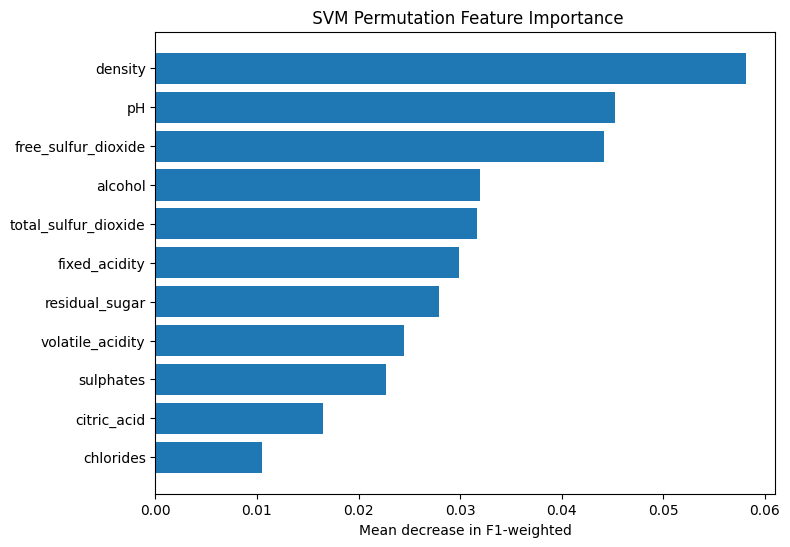

In [57]:
#experimental plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.barh(importances['feature'], importances['importance_mean'])
plt.gca().invert_yaxis()
plt.title(" SVM Permutation Feature Importance")
plt.xlabel("Mean decrease in F1-weighted")
plt.show()

In [58]:
# threshold for feature droppage
drop_thres = 0.02

selected_features = importances[importances['importance_mean'] > drop_thres]['feature']

#select features
FS_X_train = X_train[selected_features]
FS_X_val = X_val[selected_features]
FS_X_test = X_test[selected_features]

print('Selected features: ', selected_features )

Selected features:  7                  density
8                       pH
5      free_sulfur_dioxide
10                 alcohol
6     total_sulfur_dioxide
0            fixed_acidity
3           residual_sugar
1         volatile_acidity
9                sulphates
Name: feature, dtype: object


# Fitting Final Model and Performing Evaluation

In [62]:
# If using the SMOTE model, update the datasets to the SMOTE-resampled data; otherwise, leave them unchanged.
best_svc_params = FS_model.named_steps['svc'].get_params()

if Type == 'Smote':
  Final_Model = imbPipeline([
      ('scaler', StandardScaler()),
      ('smote', SafeSMOTE(random_state=17, k_neighbors=2)),
      ('svc', SVC(**best_svc_params))
  ])
else:
   Final_Model = skPipeline([
      ('scaler', StandardScaler()),
      ('svc', SVC(**best_svc_params))
  ])

Final_Model.fit(FS_X_train, y_train)


# make predictions on test
y_test_pred = Final_Model.predict(FS_X_test)

# compute metrics for test
accuracy = accuracy_score(y_test, y_test_pred)
macro_precision = precision_score(y_test, y_test_pred, average='macro',zero_division=np.nan)
macro_recall = recall_score(y_test, y_test_pred, average='macro')
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
weighted_precision = precision_score(y_test, y_test_pred, average='weighted',zero_division=np.nan)
weighted_recall = recall_score(y_test, y_test_pred, average='weighted')
weighted_f1 = f1_score(y_test, y_test_pred, average='weighted')


eval_stats = {'Type': Type + '_SVM',
      'accuracy' : accuracy,
      'macro_precision' : macro_precision,
      'weighted_precision' : weighted_precision,
      'macro_recall' : macro_recall,
      'weighted_recall' : weighted_recall,
      'macro_f1' : macro_f1,
      'weighted_f1' : weighted_f1,
      **Final_Model.named_steps['svc'].get_params()
}


print (eval_stats)

{'Type': 'Non_Smote_SVM', 'accuracy': 0.5466666666666666, 'macro_precision': 0.3940030041900545, 'weighted_precision': 0.5450149850149849, 'macro_recall': 0.23415615078206461, 'weighted_recall': 0.5466666666666666, 'macro_f1': 0.23853449257405587, 'weighted_f1': 0.5203797633532955, 'C': 3, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 1, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [60]:
print(FS_model.named_steps['svc'].support_vectors_.shape)

(3847, 11)
